In [ ]:
!pip install keras

In [ ]:
!pip install tqdm

In [ ]:
!pip install sklearn

In [ ]:
!pip install pandas

# About this kernel
This offers a boilerplate for a complete workflow for the Severstal Steel Defect Detection challenge. We will be using the popular U-Net architecture* in Keras, but I made this to be as extensible as possible so that you can experiment with different types of models. It is broken down in the following sections:

Preprocessing: Expand the train dataframe to include image ID. Also create mask_count_df which will be useful for later.

Utility Functions: Mostly copied from Paul's kernel and SIIM starter code (see references). You won't need to modify those.

Sample Test: Simply visualizing a sample image and its masks,

Data Generator: Very long and possibly complex. If you can, skip this part of the code. If you absolute need to modify the data generation process, please take a look __generate_X and __generate_y; in theory everything else should be left as is.

Model Architecture: The architecture is slightly different from the other kernels, since it learns to predict all of the four masks at the same time, instead of predicting a single mask and duplicating it. It also takes as input grayscale images.

Training: Running only for 9 epochs due to the time constraints (60 mins, this is roughly 300s per epoch).

Evaluation & Submission: The submission code is pretty messy. Essentially, I'm splitting the test dataframe into multiple chunks, then run the model and mask2rle converter on the results. I'm doing this in order to not run out of RAM as we try to convert all the masks from array to RLE.

* I might change the encoder to ResNet-34 in the future if it shows better performance... Let me know your thoughts in the comments!

References
* Data generator: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
* RLE encoding and decoding: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
* Architecture: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
* Mask encoding: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data

In [3]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [4]:
from keras import backend as K 
K.clear_session()

Using TensorFlow backend.


In [5]:

from keras.utils import multi_gpu_model
from keras.backend.tensorflow_backend import set_session

In [6]:
import numpy as np
import tensorflow as tf

In [7]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [8]:

from keras.losses import mse, binary_crossentropy

In [9]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3',
 '/job:localhost/replica:0/task:0/device:GPU:4',
 '/job:localhost/replica:0/task:0/device:GPU:5',
 '/job:localhost/replica:0/task:0/device:GPU:6',
 '/job:localhost/replica:0/task:0/device:GPU:7']

In [10]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [11]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [12]:
limit_mem()

In [13]:
base_dir = '/data/severstal-steel-defect-detection/'
train_df = pd.read_csv(base_dir+'/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [14]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [15]:
sub_df = pd.read_csv(base_dir+'/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

# Utility Functions

In [16]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [17]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

# Sample Test

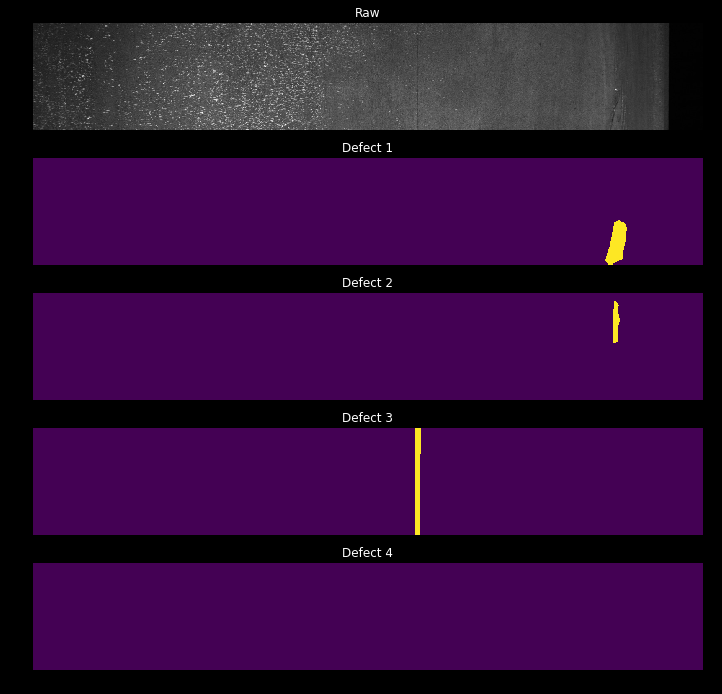

In [18]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = base_dir+"train_images/{}".format(sample_image_df['ImageId'].iloc[0])
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')
axs[0].set_title('Raw')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')
    axs[i+1].set_title('Defect {}'.format(i+1))

# Data Generator

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path= base_dir+'train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = "{}/{}".format(self.base_path, im_name)
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [20]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [56]:
train_idx.shape[0]

10682

In [58]:
val_idx.shape

(1886,)

In [57]:
mask_count_df.shape

(12568, 2)

# Model Architecture

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
def build_model(input_shape):
    
    with tf.device('/cpu:0'):
    
        inputs = Input(input_shape)

        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
        c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
        p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

        c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
        c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

        u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
        u6 = concatenate([u6, c5])
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

        u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
        u71 = concatenate([u71, c4])
        c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
        c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

        u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

        u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

        u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

        outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])
#         model.add_loss(binary_crossentropy)
    
    parallel_model = multi_gpu_model(model, gpus=8)
    parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    del model
    
    return parallel_model

# Training

In [23]:
model = build_model((256, 1600, 1))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 1600, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 1600, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 1600, 1) 0           input_1[0][0]                    
_____________________________________

In [24]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [27]:
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [28]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df.ClassId),
                                                 train_df.loc[~pd.isnull(train_df.EncodedPixels),'ClassId'])

In [29]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
#     use_multiprocessing=True,
#     workers=4,
    epochs=25,
    class_weight=class_weights
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
667/667 [==============================] - 234s 350ms/step - loss: 0.0587 - dice_coef: 0.0256 - val_loss: 0.0355 - val_dice_coef: 0.0506
Epoch 2/25
667/667 [==============================] - 206s 308ms/step - loss: 0.0328 - dice_coef: 0.0859 - val_loss: 0.0294 - val_dice_coef: 0.1297
Epoch 3/25
667/667 [==============================] - 207s 311ms/step - loss: 0.0281 - dice_coef: 0.1685 - val_loss: 0.0239 - val_dice_coef: 0.2305
Epoch 4/25
667/667 [==============================] - 205s 307ms/step - loss: 0.0238 - dice_coef: 0.2743 - val_loss: 0.0220 - val_dice_coef: 0.3110
Epoch 5/25
667/667 [==============================] - 207s 310ms/step - loss: 0.0218 - dice_coef: 0.3205 - val_loss: 0.0223 - val_dice_coef: 0.2745
Epoch 6/25
667/667 [==============================] - 209s 313ms/step - loss: 0.0205 - dice_coef: 0.3488 - val_loss: 0.0197 - val_dice_coef: 0.3595
Epoch 7/25
667/667 [==============================] - 206s 309ms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



667/667 [==============================] - 206s 309ms/step - loss: 0.0126 - dice_coef: 0.5466 - val_loss: 0.0156 - val_dice_coef: 0.4964
Epoch 23/25
667/667 [==============================] - 205s 307ms/step - loss: 0.0117 - dice_coef: 0.5727 - val_loss: 0.0147 - val_dice_coef: 0.5288
Epoch 24/25
667/667 [==============================] - 204s 306ms/step - loss: 0.0114 - dice_coef: 0.5809 - val_loss: 0.0161 - val_dice_coef: 0.5155
Epoch 25/25
667/667 [==============================] - 207s 310ms/step - loss: 0.0111 - dice_coef: 0.5891 - val_loss: 0.0187 - val_dice_coef: 0.4717


# Evaluation & Submission

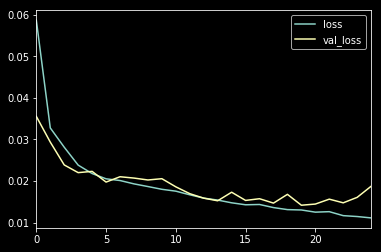

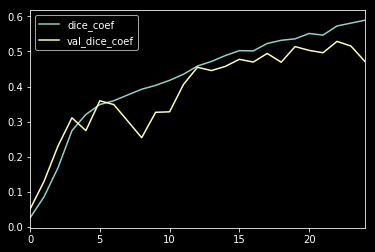

In [30]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path=base_dir+'test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

In [ ]:
test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)

In [31]:
val_idx

Int64Index([ 7232, 12204, 10006,  3655, 12140,  6118,  5938, 11153,  5393,
             6668,
            ...
             9115,  6867,  2473,  3292, 10176,  3919, 11842,  2963,  9074,
             8660],
           dtype='int64', length=1886)

# Analyse Validation Predictions

In [43]:

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [44]:

batch_pred_masks = model.predict_generator(
    val_generator, 
    workers=1,
    verbose=1,
    use_multiprocessing=False
)

117/117 [==============================] - 31s 265ms/step


In [45]:
batch_pred_masks.shape

(1872, 256, 1600, 4)

In [46]:
val_idx.shape

(1886,)

In [42]:
batch_pred_masks[0]

array([[[8.40425491e-06, 0.00000000e+00, 2.31313705e-03, 2.80946493e-04],
        [1.19209290e-07, 0.00000000e+00, 7.23302364e-05, 3.15904617e-06],
        [5.96046448e-08, 0.00000000e+00, 7.17639923e-05, 6.55651093e-07],
        ...,
        [1.78813934e-07, 0.00000000e+00, 1.98841095e-04, 2.23517418e-06],
        [1.19209290e-07, 0.00000000e+00, 7.99894333e-04, 3.10242176e-05],
        [2.44379044e-06, 0.00000000e+00, 2.41896510e-03, 1.91986561e-04]],

       [[1.31130219e-06, 5.96046448e-08, 7.43567944e-05, 2.35587358e-04],
        [1.19209290e-07, 0.00000000e+00, 4.47332859e-05, 0.00000000e+00],
        [6.25848770e-07, 0.00000000e+00, 6.07073307e-05, 0.00000000e+00],
        ...,
        [1.19209290e-07, 0.00000000e+00, 1.04248524e-04, 5.96046448e-08],
        [0.00000000e+00, 0.00000000e+00, 4.24563885e-04, 2.98023224e-08],
        [0.00000000e+00, 0.00000000e+00, 2.64018774e-04, 3.57627869e-07]],

       [[5.27501106e-06, 3.57627869e-07, 2.09599733e-04, 4.26173210e-06],
        

In [47]:
train_df.loc[val_idx].shape

(1886, 5)

In [48]:
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [49]:
tmp = '0002cc93b.jpg'

In [67]:
def predict_one(imageId):
    
    idx = mask_count_df[mask_count_df.ImageId==tmp].index
    
    generator = DataGenerator(
        idx, 
        df=mask_count_df,
        target_df=train_df,
        batch_size=1, 
        n_classes=4
    )
    
    return model.predict_generator(
        generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )[0]

In [68]:
x = predict_one(tmp)

1/1 [==============================] - 0s 44ms/step


In [69]:
x.shape

(256, 1600, 4)

In [76]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [77]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [78]:
def read_image(imageId):
    sample_image_df = train_df[train_df['ImageId'] == imageId]
    sample_path = base_dir+"train_images/{}".format(sample_image_df['ImageId'].iloc[0])
    sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    sample_rles = sample_image_df['EncodedPixels'].values
    sample_masks = build_masks(sample_rles, input_shape=(256, 1600))
    
    return sample_img, sample_masks

In [79]:
def show_images(image, masks):
    
    fig, axs = plt.subplots(5, figsize=(12, 12))
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Raw')

    for i in range(4):
        axs[i+1].imshow(masks[:, :, i])
        axs[i+1].axis('off')
        axs[i+1].set_title('Defect {}'.format(i+1))

In [ ]:
show_images(img,masks)

In [74]:
def show_true_vs_pred(image, pred_masks, true_masks):
    
    fig,ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.imshow(image, cmap='gray')
    
    plt.show()
    
    fig, axs = plt.subplots((4,2), figsize=(12, 12))

    for i in range(4):
        axs[i][0].imshow(pred_masks[:, :, i])
        axs[i][0].axis('off')
        axs[i][0].set_title('Defect {} Predicted'.format(i+1))
    
        axs[i][1].imshow(true_masks[:, :, i])
        axs[i][1].axis('off')
        axs[i][1].set_title('Defect {} True'.format(i+1))
    
    plt.show()

In [80]:
img, true_masks = read_image(imageId)

NameError: name 'imageId' is not defined

In [ ]:
show_true_vs_pred(img, )